In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

from delfi.utils.viz import plot_pdf
from tqdm import tqdm_notebook as tqdm
from parameters import ParameterSet

import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.summarystats as ds
import delfi.kernel as dk
from delfi.simulator.BaseSimulator import BaseSimulator
import delfi.utils.viz as dv


In [12]:
params = ParameterSet({})

params.seed = 239

params.infer = ParameterSet({})
params.infer.n_components = 1
params.infer.n_hiddens = [10, 10]
params.infer.pilot_samples = 100
params.infer.svi = False
params.infer.prior_norm = True

params.run = ParameterSet({})
params.run.n_train = 100000
#params.run.minibatch = 100
params.run.epochs = 200
#params.run.lr = 0.02

In [13]:
prior_mean = 2
prior_var = 0.5

prop_prior_mean=1.09090909
prop_prior_var=0.11615753

noise_var = 0.01

gt = np.array([ 0.6 ])

In [14]:
def gauss(x, mean, cov):
    covi = np.linalg.inv(cov)
    dots = np.einsum('...i,ij,...j', x - mean, covi, x - mean)
    ret = 1 / np.sqrt(2 * np.pi * np.linalg.det(cov)) * np.exp(-0.5 * dots)
    assert ret.shape == x.shape[:-1]
    return ret

class ForwardModel(BaseSimulator):
    def __init__(self, seed=None):
        super().__init__(dim_param=1, seed=seed)
        self.noise_std = np.sqrt(noise_var)
    
    def gen_single(self, params):
        means = self.get_means(params)
        sample = means + self.noise_std * self.rng.normal(size=params.shape)
        return { "data" :  np.array(sample) }
    
    def likelihood(self, x, params):
        means = self.get_means(params)
        diffs = means - x
        ret = gauss(diffs.reshape(-1,1), [0], (self.noise_std ** 2) * np.eye(1))
        return ret
        
    def get_means(self, params):
        return np.sign(params) * (np.abs(params) ** (1/3))
    
    def get_mle(self, params):
        return np.asarray(params) ** 3

In [15]:
def init_g(seed):
    

    m = ForwardModel(seed=seed)
    prior = dd.Gaussian(m=[prior_mean], S=[[prior_var]], seed=seed+1)
    prop_prior = dd.Gaussian(m=[prop_prior_mean], S=[[prop_prior_var]], seed=seed+2)
    s = ds.Identity(1)

    return dg.Default(m, prior, s, seed=seed+3)

g = init_g(params.seed)
xobs = g.model.get_means(gt)

res = infer.SNPE(generator=g, obs=[xobs], verbose=True, **params.infer)

logs, tds, posteriors = res.run(n_rounds=1, **params.run)

posterior = posteriors[-1]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [16]:
g = init_g(params.seed)
g.prior = dd.Gaussian(m=[prop_prior_mean], S=[[prop_prior_var]], seed=params.seed+1234)

res_uncorr = infer.SNPE(generator=g, obs=[xobs], verbose=True, **params.infer)

logs, tds, posteriors_uncorr = res_uncorr.run(n_rounds=1, **params.run)


posterior_uncorr = posteriors_uncorr[-1]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [17]:
g = init_g(params.seed)
proposal = dd.Gaussian(m=[prop_prior_mean], S=[[prop_prior_var]], seed=params.seed+1234)

res_SNPE = infer.SNPE(generator=g, obs=[xobs], verbose=True, convert_to_T=None, **params.infer)

logs, tds, posteriors_SNPE = res_SNPE.run(n_rounds=1, impute_proposal = proposal, **params.run)

posterior_SNPE = posteriors_SNPE[-1]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

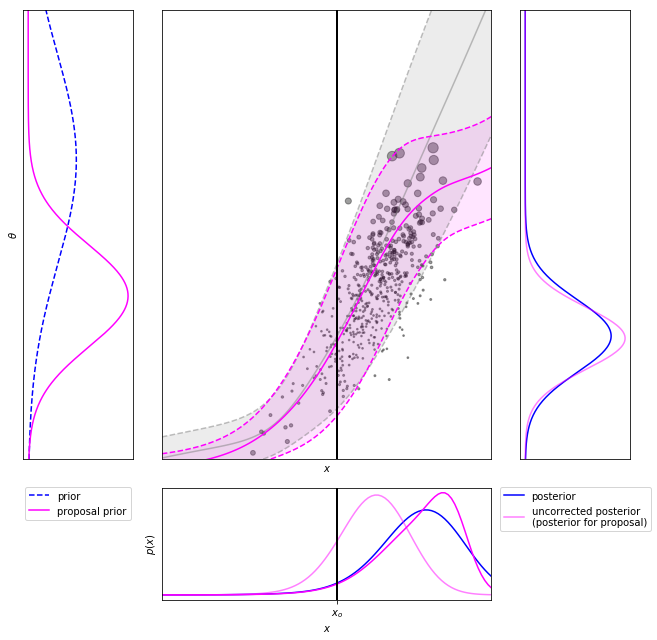

In [18]:
fig = plt.figure(figsize=(9,9))

###############################################################################
# sampling from proposal prior and running forward model
n_samp = 500
np.random.seed(44)

g = init_g(params.seed)
g.proposal = dd.Gaussian(m=[prop_prior_mean], S=[[prop_prior_var]], seed=params.seed)
theta_samp = (np.sqrt(prop_prior_var) * np.random.randn(n_samp) + prop_prior_mean).reshape(-1,1)
x_samp = np.sqrt(noise_var) * np.random.randn(n_samp) + g.model.get_means(theta_samp).flatten()
#theta_samp = (tds[-1][0].reshape(-1,1) * res_SNPE.params_std) + res_SNPE.params_mean
#x_samp     = (tds[-1][1].reshape(-1,1) * res_SNPE.stats_std)  + res_SNPE.stats_mean

theta_lims = [0, 3]
thetas = np.linspace(theta_lims[0], theta_lims[1], 500)

xlims = [0, g.model.get_means(theta_lims[1]) * 1.1]

xs = np.linspace(xlims[0], xlims[1], 100)

posts = [ res.predict([[x]]) for x in xs ]
post_means = np.array([ post.xs[0].m[0] for post in posts ])
post_vars = np.array([ post.xs[0].S[0,0] for post in posts ])

posts_SNPE = [ res_SNPE.predict([[x]]) for x in xs ]
post_means_SNPE = np.array([ post.xs[0].m[0] for post in posts_SNPE ])
post_vars_SNPE = np.array([ post.xs[0].S[0,0] for post in posts_SNPE ])

gs = gridspec.GridSpec(2, 3, width_ratios=[1, 3, 1], height_ratios=[4,1])

prior_col = "blue"
prop_prior_col = "magenta"
post_col = "blue"
post_uncorr_col = "magenta"

# LEFTHAND SIDE
axl = plt.subplot(gs[0,0])
#plt.plot(prop_prior, yy, '--',color='0.55', label='proposal prior')
plt.plot(g.prior.eval(thetas.reshape(-1,1), log=False), thetas, '--', c=prior_col, label='prior')
plt.plot(g.proposal.eval(thetas.reshape(-1,1), log=False), thetas, c=prop_prior_col, label='proposal prior')

axl.set_ylim(theta_lims)
axl.set_yticks([])
axl.set_xticks([])
plt.ylabel(r'$\theta$')
axl.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  ncol=1)

axr = plt.subplot(gs[0,2])



# RIGHTHAND SIDE
plt.plot(posterior.eval(thetas.reshape(-1,1), log=False), thetas, c=post_col, label='posterior')
plt.plot(posterior_uncorr.eval(thetas.reshape(-1,1), log=False), thetas, 
         alpha=0.5, c=post_uncorr_col, label='uncorrected posterior \n(posterior for proposal)')
#    plt.plot(pp_post,yy,color=col_2, label='posterior')
#plt.plot(pp_param,yy,color=col_3, label='parametrised posterior')
axr.set_ylim(theta_lims)
#ax.set_xticks([])
axr.set_xticks([])
plt.ylabel('')
axr.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=1)
#plt.legend(bbox_to_anchor=(1.25, 1), loc='upper right')


hl, ll = axl.get_legend_handles_labels()
hr, lr = axr.get_legend_handles_labels()
axr.set_yticks([])

axm = plt.subplot(gs[0,1])
plt.ylabel('')

iws = np.exp(g.prior.eval(theta_samp, log=True) - g.proposal.eval(theta_samp, log=True))

# Draw true posterior
plt.scatter(x_samp, theta_samp.flatten(), color='0.05', s=30 * np.log((1.1 - np.min(iws)) + iws), alpha=0.4)
#plt.plot(x0_grid, true_means, color = '0.0', label='true posterior')
#plt.plot(x0_grid, fake_means, color = col_0, label='true posterior')

#plt.plot(x0_grid,true_means + 2 * np.sqrt(true_covs),'--',color=col_0)
#plt.plot(x0_grid,true_means - 2 * np.sqrt(true_covs),'--',color=col_0)
#plt.fill_between(x0_grid,fake_means-2 * np.sqrt(fake_covs),
#                 fake_means+2 * np.sqrt(fake_covs),
#                 facecolor=col_0,
#                 alpha=0.15)

# Draw posterior means (in orange)
std_col = plt.get_cmap("tab10")(0)

std_col = 'gray'

plt.plot(xs,post_means, c=std_col, label='posterior', alpha=0.5)
plt.plot(xs,post_means + 2 * np.sqrt(post_vars),ls='--', c=std_col, alpha=0.5)
plt.plot(xs,post_means - 2 * np.sqrt(post_vars),ls='--', c=std_col, alpha=0.5)

plt.fill_between(xs,post_means-2 * np.sqrt(post_vars),
                 post_means+2 * np.sqrt(post_vars), facecolor=std_col,
                 alpha=0.15)


std_col = prop_prior_col

plt.plot(xs,post_means_SNPE, c=std_col, label='SNPE')
plt.plot(xs,post_means_SNPE + 2 * np.sqrt(post_vars_SNPE),ls='--', c=std_col)
plt.plot(xs,post_means_SNPE - 2 * np.sqrt(post_vars_SNPE),ls='--', c=std_col)

plt.fill_between(xs,post_means_SNPE-2 * np.sqrt(post_vars_SNPE),
                 post_means_SNPE+2 * np.sqrt(post_vars_SNPE), facecolor=std_col,
                 alpha=0.1)

# Draw vertical lines around chosen point
axm.axvline(xobs,lw=2, c='k')
#     axm.vlines(obs_stats-eps, 0, axm.get_ylim()[1], lw=1, color='0.25')
#     axm.vlines(obs_stats+eps, 0, axm.get_ylim()[1], lw=1, color='0.25')

axm.set_xlim(xlims)
axm.set_ylim(theta_lims)
axm.set_xticks([])
axm.set_yticks([])
#plt.xlabel('x')
#plt.legend(bbox_to_anchor=(0.0, 1), loc='upper left')

#plt.xticks([xobs], [r'$x_{o}$'])

axm.set_xlabel("$x$")

axb = plt.subplot(gs[1,1])


#### COMPUTE MARGINALS

def compute_marginals(prop, prior=None):
    thetas = prop.gen(100000)
    
    means = g.model.get_means(thetas)
    
    ret = means + np.sqrt(noise_var) * np.random.normal(size=thetas.shape)
    
    if prior is None:
        return ret
    else:
        iws = prior.eval(thetas, log=False) / prop.eval(thetas, log=False)
        iws /= np.mean(iws)
        
        return ret, iws
    
prior_marg_samples = compute_marginals(g.prior)
prop_prior_marg_samples, marg_iws = compute_marginals(g.proposal, g.prior)

from sklearn.neighbors.kde import KernelDensity

prior_marg_density = KernelDensity(kernel='gaussian', 
                                   bandwidth=0.05 * (xlims[1] - xlims[0])).fit(prior_marg_samples)
prop_prior_marg_density = KernelDensity(kernel='gaussian', 
                                       bandwidth=0.05 * (xlims[1] - xlims[0])).fit(prop_prior_marg_samples)
iw_marg_density = KernelDensity(kernel='gaussian', 
                                bandwidth=0.05 * (xlims[1] - xlims[0])).fit(prop_prior_marg_samples, sample_weight=marg_iws)

plt.plot(xs, np.exp(prior_marg_density.score_samples(xs.reshape(-1,1))), c=prior_col, label='prior')
plt.plot(xs, np.exp(prop_prior_marg_density.score_samples(xs.reshape(-1,1))), c=prop_prior_col, alpha=0.5, label='proposal prior')
plt.plot(xs, np.exp(iw_marg_density.score_samples(xs.reshape(-1,1))), c=prop_prior_col, label='importance weighted')


##########

#plt.hist(prop_prior_marg_samples.reshape(-1), bins=50, normed=True, weights=marg_iws, color=prop_prior_col, alpha=0.5)

#plt.plot(xs, gen_mod.eval(xs.reshape(-1,1), log=False), color='0.0', label='marginal')

axb.set_xlim(xlims)
axb.set_xticks([])
plt.xticks([xobs], [r'$x_{o}$'])
axb.set_yticks([])

axb.set_xlabel("$x$")
axb.set_ylabel("$p(x)$")
#axb.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
 #          fancybox=True, shadow=True, ncol=1)

axb.axvline(xobs, lw=2, c='k')


plt.tight_layout()

plt.savefig('CDE_with_proposal.pdf')

plt.show()

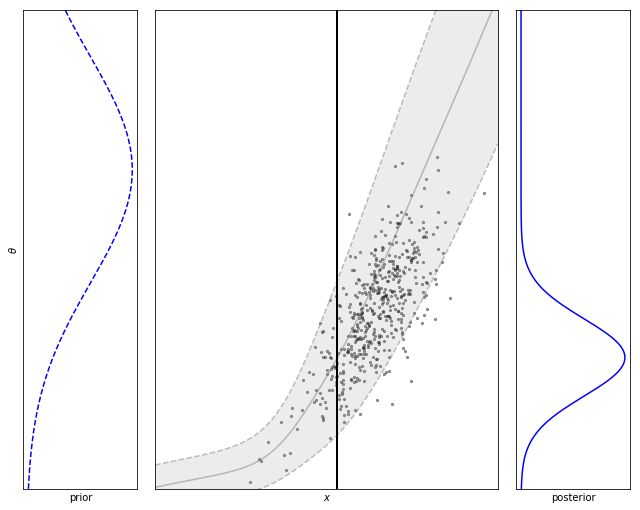

In [19]:
fig = plt.figure(figsize=(9,9))

###############################################################################
# sampling from proposal prior and running forward model
n_samp = 500
np.random.seed(44)

g = init_g(params.seed)
g.proposal = dd.Gaussian(m=[prop_prior_mean], S=[[prop_prior_var]], seed=params.seed)
theta_samp = (np.sqrt(prop_prior_var) * np.random.randn(n_samp) + prop_prior_mean).reshape(-1,1)
x_samp = np.sqrt(noise_var) * np.random.randn(n_samp) + g.model.get_means(theta_samp).flatten()
#theta_samp = (tds[-1][0].reshape(-1,1) * res_SNPE.params_std) + res_SNPE.params_mean
#x_samp     = (tds[-1][1].reshape(-1,1) * res_SNPE.stats_std)  + res_SNPE.stats_mean

theta_lims = [0, 3]
thetas = np.linspace(theta_lims[0], theta_lims[1], 500)

xlims = [0, g.model.get_means(theta_lims[1]) * 1.1]

xs = np.linspace(xlims[0], xlims[1], 100)

posts = [ res.predict([[x]]) for x in xs ]
post_means = np.array([ post.xs[0].m[0] for post in posts ])
post_vars = np.array([ post.xs[0].S[0,0] for post in posts ])

posts_SNPE = [ res_SNPE.predict([[x]]) for x in xs ]
post_means_SNPE = np.array([ post.xs[0].m[0] for post in posts_SNPE ])
post_vars_SNPE = np.array([ post.xs[0].S[0,0] for post in posts_SNPE ])

gs = gridspec.GridSpec(2, 3, width_ratios=[1, 3, 1], height_ratios=[4,1])

prior_col = "blue"
prop_prior_col = "magenta"
post_col = "blue"
post_uncorr_col = "magenta"

# LEFTHAND SIDE
axl = plt.subplot(gs[0,0])
plt.plot(g.prior.eval(thetas.reshape(-1,1), log=False), thetas, '--', c=prior_col, label='prior')
axl.set_ylim(theta_lims)
axl.set_yticks([])
axl.set_xticks([])
plt.ylabel(r'$\theta$')
plt.xlabel('prior')
#axl.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  ncol=1)

axr = plt.subplot(gs[0,2])



# RIGHTHAND SIDE
plt.plot(posterior.eval(thetas.reshape(-1,1), log=False), thetas, c=post_col, label='posterior')
axr.set_ylim(theta_lims)
#ax.set_xticks([])
axr.set_xticks([])
plt.ylabel('')
#axr.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=1)
plt.xlabel('posterior')
#plt.legend(bbox_to_anchor=(1.25, 1), loc='upper right')


hl, ll = axl.get_legend_handles_labels()
hr, lr = axr.get_legend_handles_labels()
axr.set_yticks([])

axm = plt.subplot(gs[0,1])
plt.ylabel('')

iws = np.exp(g.prior.eval(theta_samp, log=True) - g.proposal.eval(theta_samp, log=True))

# Draw true posterior
plt.scatter(x_samp, theta_samp.flatten(), color='0.05', s=5,alpha=0.4)
#plt.plot(x0_grid, true_means, color = '0.0', label='true posterior')
#plt.plot(x0_grid, fake_means, color = col_0, label='true posterior')

#plt.plot(x0_grid,true_means + 2 * np.sqrt(true_covs),'--',color=col_0)
#plt.plot(x0_grid,true_means - 2 * np.sqrt(true_covs),'--',color=col_0)
#plt.fill_between(x0_grid,fake_means-2 * np.sqrt(fake_covs),
#                 fake_means+2 * np.sqrt(fake_covs),
#                 facecolor=col_0,
#                 alpha=0.15)

# Draw posterior means (in orange)
std_col = plt.get_cmap("tab10")(0)

std_col = 'gray'

plt.plot(xs,post_means, c=std_col, label='posterior', alpha=0.5)
plt.plot(xs,post_means + 2 * np.sqrt(post_vars),ls='--', c=std_col, alpha=0.5)
plt.plot(xs,post_means - 2 * np.sqrt(post_vars),ls='--', c=std_col, alpha=0.5)

plt.fill_between(xs,post_means-2 * np.sqrt(post_vars),
                 post_means+2 * np.sqrt(post_vars), facecolor=std_col,
                 alpha=0.15)


# Draw vertical lines around chosen point
axm.axvline(xobs,lw=2, c='k')
#     axm.vlines(obs_stats-eps, 0, axm.get_ylim()[1], lw=1, color='0.25')
#     axm.vlines(obs_stats+eps, 0, axm.get_ylim()[1], lw=1, color='0.25')

axm.set_xlim(xlims)
axm.set_ylim(theta_lims)
axm.set_xticks([])
axm.set_yticks([])
#plt.xlabel('x')
#plt.legend(bbox_to_anchor=(0.0, 1), loc='upper left')

#plt.xticks([xobs], [r'$x_{o}$'])

axm.set_xlabel("$x$")

plt.tight_layout()

plt.savefig('CDE_with_prior.pdf')

plt.show()

A Jupyter Widget

A Jupyter Widget


Var[th] =  0.343419859961


/Users/kaan/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


A Jupyter Widget

A Jupyter Widget


Var[th] =  0.214367014656


A Jupyter Widget

A Jupyter Widget


Var[th] =  0.11416936669


A Jupyter Widget

A Jupyter Widget


Var[th] =  0.0499212207421


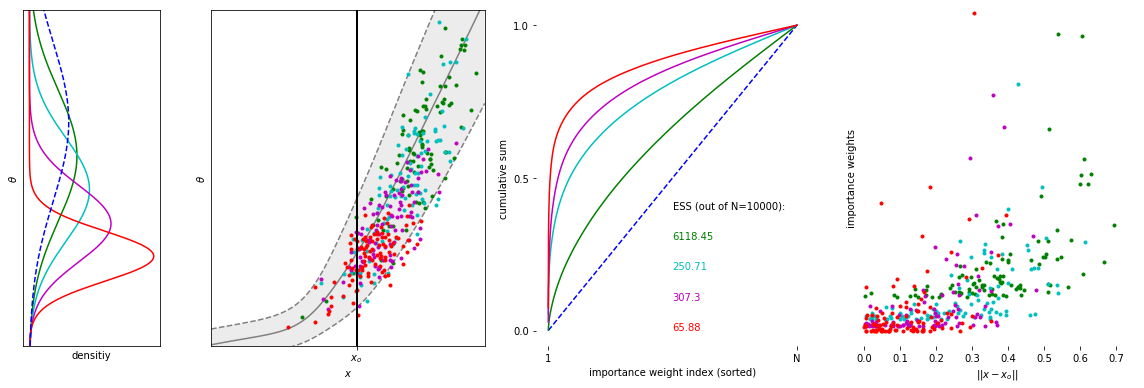

In [20]:
from scipy.misc import logsumexp

N = 10000
N_show = 100

seed = 43
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 2, 2, 2], height_ratios=[1])

def init_g(seed):
    

    m = ForwardModel(seed=seed)
    prior = dd.Gaussian(m=[prior_mean], S=[[prior_var]], seed=seed+1)
    prop_prior = dd.Gaussian(m=[prop_prior_mean], S=[[prop_prior_var]], seed=seed+2)
    s = ds.Identity(1)

    return dg.Default(m, prior, s, seed=seed+3)

p_true = dd.Gaussian(m=0.8*np.ones(1), S=0.05*np.eye(1), seed = seed)
obs_stats = 0.84343267 * np.ones((1,1))

sig2s = np.linspace(np.sqrt(0.05), np.sqrt(0.5), 100)**2
sig2s = sig2s[::-1][[25, 50, 75, 99]]
ms    = np.linspace(0.8, 2., 100)
ms    = ms[::-1][[25, 50, 75, 99]]


clrs = ['g', 'c',  'm', 'r']

theta_lims = [0, 3]
xx = np.linspace(theta_lims[0], theta_lims[1], 500).reshape(-1,1)
g = init_g(seed)
xlims = [0, g.model.get_means(theta_lims[1]) * 1.1]

plt.figure(figsize=(16,5.5))

ax = plt.subplot(gs[0,1])
std_col = 'gray'
ax.plot(xs,post_means, c=std_col, label='posterior')
ax.plot(xs,post_means + 2 * np.sqrt(post_vars),ls='--', c=std_col)
ax.plot(xs,post_means - 2 * np.sqrt(post_vars),ls='--', c=std_col)
plt.fill_between(xs,post_means-2 * np.sqrt(post_vars),
                 post_means+2 * np.sqrt(post_vars), facecolor=std_col,
                 alpha=0.15)

ax = plt.subplot(gs[0,2])
ax.plot([1,N],[0,1], 'b--', label='prior')


for i in range(len(sig2s)):
    
    sig2 = sig2s[i]
    m = ms[i]
    p_prop = dd.Gaussian(m=m*np.ones(1), S = sig2*np.eye(1), seed=seed+1234+i)

    g = init_g(seed)
    g.proposal = p_prop
    trn_data = g.gen(N)

    print('Var[th] = ', trn_data[0].var())

    ax = plt.subplot(gs[0,0])
    ax.plot(  p_prop.eval(xx, log=False), xx, '-', color=clrs[i])

    ax = plt.subplot(gs[0,1])
    x_samp, theta_samp = trn_data[1][:N_show], trn_data[0][:N_show]
    ax.plot( x_samp, theta_samp, '.', color=clrs[i])    
    #iws = np.exp(g.prior.eval(theta_samp, log=True) - g.proposal.eval(theta_samp, log=True))
    #ax.scatter(x_samp, theta_samp.flatten(), color=clrs[i], s=30 * np.log((1.1 - np.min(iws)) + iws), alpha=0.4)
    plt.xlabel("$x$")
    plt.ylabel(r'$\theta$')
    
    ax = plt.subplot(gs[0,2])    
    liws = (g.prior.eval(trn_data[0]) - g.proposal.eval(trn_data[0]))
    iws = np.exp(liws - logsumexp(liws))
    ax.plot(np.arange(iws.size)+1, np.cumsum(np.sort(iws)[::-1]), '-', color=clrs[i])
    plt.xlabel('importance weight index (sorted)')
    plt.ylabel('cumulative sum')
    
    ESS = 1./np.sum( (iws/iws.sum())**2 )
    plt.text(N/2, (len(sig2s)-i-1)*0.1, str(np.round(ESS*100)/(100)), color=clrs[i])
    
    ax = plt.subplot(gs[0,3])
    dists = np.sqrt( np.sum( (trn_data[1] - obs_stats)**2, axis=1) )
    ax.plot( dists[:N_show], iws[:N_show], '.', color=clrs[i])
    plt.xlabel("$|| x - x_o ||$")
    plt.ylabel('importance weights')
    
ax = plt.subplot(gs[0,0])
#ax.plot( p_true.eval(xx, log=False), xx, '-', color='k')
ax.plot( g.prior.eval(xx, log=False), xx, '--', color='b')
plt.ylabel(r'$\theta$')
plt.xlabel('densitiy')
#plt.box('off')
plt.yticks([])
plt.xticks([])
ax.set_ylim(theta_lims)

ax = plt.subplot(gs[0,1])
#plt.box('off')
plt.xticks([])
plt.yticks([])
ax.set_ylim(theta_lims)
ax.set_xlim(xlims)
ax.axvline(xobs, lw=2, c='k')
plt.xticks([xobs], [r'$x_{o}$'])

ax = plt.subplot(gs[0,2])
plt.box('off')
plt.xticks([1, N], ['1', 'N'])
plt.yticks([0, 0.5, 1.])
plt.text(N/2, (len(sig2s))*0.1, 'ESS (out of N='+str(N)+'):', color='k')

ax = plt.subplot(gs[0,3])
plt.yticks([])
plt.box('off')
plt.axis([-0.01, 0.75, 0, np.max(iws[:N_show])*1.01])

plt.tight_layout()

plt.savefig('importance_weights_vs_distance.pdf')

plt.show()